## make semi supervised

In [1]:
from genepy.utils import helper as h

# to comment in your case
from taigapy import TaigaClient
tc = TaigaClient()

from celligner2.dataset import anndata
import pandas as pd
# to comment in your case
from depmapomics import tracker as track

from collections import Counter

#autoreload
%load_ext autoreload
%autoreload 2
#output
from bokeh.plotting import output_notebook
output_notebook()
from anndata import AnnData, read_h5ad

import scanpy as sc
import torch
import matplotlib.pyplot as plt
import numpy as np
import gdown

import celligner2

Loading BokehJS ...

In [7]:
sc.settings.set_figure_params(dpi=500, frameon=False)
sc.set_figure_params(dpi=500)
sc.set_figure_params(figsize=(10, 10))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [291]:
cl2 = dataset.var

""
ENSG00000148400
ENSG00000156802
ENSG00000123388
ENSG00000259120
ENSG00000170858
...
ENSG00000156795
ENSG00000233885
ENSG00000187446
ENSG00000187583


In [289]:
dataset = read_h5ad("temp/celligner_multi.h5ad.gz")

In [162]:
Counter(dataset.obs.tissue_type)

Counter({'lung': 1308,
         'soft_tissue': 552,
         'skin': 557,
         'bile_duct': 79,
         'urinary_tract': 443,
         'colorectal': 454,
         'lymphocyte': 181,
         'uterus': 278,
         'gastric': 461,
         'kidney': 1057,
         'pancreas': 232,
         'central_nervous_system': 1307,
         'fibroblast': 39,
         'breast': 1160,
         'bone': 302,
         'upper_aerodigestive': 576,
         'ovary': 491,
         'cervix': 325,
         'blood': 1221,
         'esophagus': 214,
         nan: 25,
         'liver': 422,
         'peripheral_nervous_system': 212,
         'eye': 92,
         'thyroid': 532,
         'plasma_cell': 29,
         'engineered_central_nervous_system': 1,
         'embryo': 3,
         'engineered_kidney': 2,
         'prostate': 507,
         'engineered_ovary': 1,
         'engineered': 6,
         'engineered_prostate': 1,
         'engineered_lung': 1,
         'adrenal_cortex': 1,
         'engineered_b

In [304]:
dataset.obs.cell_type = dataset.obs.cell_type.replace({'historical_CL; 2D':'historical_cl'})

In [305]:
rename = {np.nan: "unknown", "adrenal_cortex": "adrenal", "colorectal": "colon", 'thymus': 'thyroid',}
dataset.obs.tissue_type = dataset.obs.tissue_type.replace(rename)

In [306]:
for val in ['ends', 'reference', 'method', 'sequencer']:
    print(val, set(dataset.obs[val]))

ends {'paired end'}
reference {'hg38'}
method {'bulk'}
sequencer {'Illumina Hiseq 2000'}


In [307]:
loc = np.argsort(dataset.X.var(0))[-3000:]
dataset = AnnData(dataset.X[:,loc], dataset.obs, dataset.var.iloc[loc])

In [168]:
set(dataset.obs.sex)

{'Female', 'Male', 'U', 'female', 'male', nan, 'not reported', 'unknown'}

In [308]:
dataset.obs.sex = dataset.obs.sex.str.lower()

In [309]:
for val in ['tissue_type', 'age', "sex", 'disease_type']:  
    loc = dataset.obs[val].isin(['unknown', 'not reported', 'Unknown', 'u']) | dataset.obs[val].isna()
    try:
        dataset.obs.loc[loc, val] = 'U'
    except ValueError:
        dataset.obs[val] = dataset.obs[val].cat.add_categories('U')
        dataset.obs.loc[loc, val] = 'U'

In [310]:
# removing ultra rare samples
loc = dataset.obs["disease_type"].isin([
'Teratoma',
'Thymic Cancer',
'Nasopharyngeal Cancer',
'U',
'Endocrine Cancer',
'Pineal Cancer',
'Embryonal Cancer',
"Gallbladder Cancer"]) | dataset.obs["tissue_type"].isin([
'engineered_central_nervous_system',
'embryo',
'engineered_kidney',
'engineered_ovary',
'engineered',
'engineered_prostate',
'engineered_lung',
'adrenal_cortex',
'engineered_blood',
'engineered_breast',
'colon',
'nasopharynx',
'teratoma',
'endocrine',
'pineal'])

dataset = AnnData(dataset.X[~loc.values], dataset.obs[~loc])

In [12]:
#TODO: try batch norm use_bn=True, use_ln=False, https://stats.stackexchange.com/questions/474440/why-do-transformers-use-layer-norm-instead-of-batch-norm
#TODO

In [255]:
loc = dataset.obs.cell_type=='tumor'
subdataset = AnnData(dataset.X[loc.values], dataset.obs[loc])

In [311]:
cl2_less = celligner2.CELLIGNER2(
    adata=dataset,
    condition_keys=['cell_type'],
    predictor_keys=['tissue_type', 'age', "sex", 'disease_type'],
    hidden_layer_sizes=[256, 128],
    classifier_hidden_layer_sizes=[32,64],
    use_mmd = True,
    latent_dim=16,
    beta=500,
    betaclass=0.8
)
cl2_less.train(
    n_epochs=300,
    alpha_epoch_anneal=200,
    early_stopping_kwargs= {
        "early_stopping_metric": "val_unweighted_loss",
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    },
    alpha_kl=0.001,
    train_frac=0.75,
    #batch_size=100,
    #monitor_only_val=False,
    n_workers=16,
    min_weight=0.000001,
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 3000 256 2
	Hidden Layer 1 in/out: 256 128
	Mean/Var Layer in/out: 128 16
Classifier Architecture:
	First Layer in/out:  16 32
	Hidden Layer 1 in/out: 32 64
	Output Layer in/out:  64 65 

Decoder Architecture:
	First Layer in, out and cond:  16 128 2
	Hidden Layer 1 in/out: 128 256
	Output Layer in/out:  256 3000 

Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1


/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


 |████████------------| 42.0%  - val_loss: 4951.8182279147 - val_recon_loss: 4497.6451322115 - val_kl_loss: 65.8439492446 - val_class_ce_loss: 163.6756106157 - val_mmd_loss: 290.4564789992
ADJUSTED LR
 |██████████----------| 53.3%  - val_loss: 4884.2239896334 - val_recon_loss: 4463.3602201022 - val_kl_loss: 65.8521370521 - val_class_ce_loss: 143.6092048058 - val_mmd_loss: 277.2023133498
ADJUSTED LR
 |███████████---------| 55.7%  - val_loss: 4889.8700608474 - val_recon_loss: 4460.5258225661 - val_kl_loss: 65.8496985802 - val_class_ce_loss: 143.3471116286 - val_mmd_loss: 285.9424456083
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 145


In [312]:
#from celligner2 import plotting as pl
evaluator_less = pl.CELLIGNER2_EVAL(cl2_less)

In [313]:
evaluator_less.get_class_quality(classes=['tissue_type', 'disease_type', 'sex', 'age'])

tissue_type
all predicted categories:  {'pancreas', 'thyroid', 'germ_cell', 'uterus', 'bone', 'nerve', 'bile_duct', 'plasma_cell', 'urinary_tract', 'fibroblast', 'liver', 'central_nervous_system', 'breast', 'esophagus', 'peripheral_nervous_system', 'gastric', 'lung', 'soft_tissue', 'eye', 'ovary', 'prostate', 'cervix', 'kidney', 'blood', 'skin', 'adrenal', 'lymphocyte', 'upper_aerodigestive'}
percent of correct predictions:  0.98776502773767


disease_type
all predicted categories:  {'Brain Cancer', 'Leukemia', 'Prostate Cancer', 'Lymphoma', 'Breast Cancer', 'Gastric Cancer', 'Endometrial/Uterine Cancer', 'Skin Cancer', 'Head and Neck Cancer', 'Liver Cancer', 'Pancreatic Cancer', 'Bladder Cancer', 'Ovarian Cancer', 'Cervical Cancer', 'Rhabdoid', 'Liposarcoma', 'Thyroid Cancer', 'Thymus Cancer', 'Nerve', 'normal', 'Bone Cancer', 'Adrenal Cancer', 'Myeloma', 'Germ Cell Cancer', 'Sarcoma', 'Kidney Cancer', 'Neuroblastoma', 'Eye Cancer', 'Lung Cancer', 'Bile Duct Cancer', 'Esophageal Cance

In [ ]:
conf = evaluator_less.getconfusionMatrix(only=None)

In [ ]:
conf = evaluator_less.getconfusionMatrix(only="historical_cl")

In [ ]:
del cl2_less, evaluator_less

In [263]:
cl2 = celligner2.CELLIGNER2(
    adata=dataset,
    condition_keys=['cell_type'],
    predictor_keys=['tissue_type', 'age', "sex", 'disease_type'],
    hidden_layer_sizes=[256, 128],
    classifier_hidden_layer_sizes=[32,64],
    use_mmd = True,
    latent_dim=16,
    beta=500,
    betaclass=0.8
)
cl2.train(
    n_epochs=300,
    alpha_epoch_anneal=200,
    early_stopping_kwargs= {
        "early_stopping_metric": "val_unweighted_loss",
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    },
    alpha_kl=0.001,
    #batch_size=100,
    #monitor_only_val=False,
    n_workers=16,
    min_weight=0.000001,
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 3000 256 2
	Hidden Layer 1 in/out: 256 128
	Mean/Var Layer in/out: 128 16
Classifier Architecture:
	First Layer in/out:  16 32
	Hidden Layer 1 in/out: 32 64
	Output Layer in/out:  64 65 

Decoder Architecture:
	First Layer in, out and cond:  16 128 2
	Hidden Layer 1 in/out: 128 256
	Output Layer in/out:  256 3000 

Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
 |█████---------------| 28.3%  - val_loss: 4929.2739701705 - val_recon_loss: 4488.7249644886 - val_kl_loss: 65.8479399248 - val_class_ce_loss: 145.5458915017 - val_mmd_loss: 294.9753653786
ADJUSTED LR
 |██████--------------| 30.7%  - val_loss: 4936.0191317472 - val_recon_

In [274]:
#from celligner2 import plotting as pl
evaluator = pl.CELLIGNER2_EVAL(cl2)

> /home/jeremie/celligner2/celligner2/model/celligner2_model.py(236)get_latent()
    234             adata = self.adata
    235         import pdb; pdb.set_trace()
--> 236         condition_sets = {key: set(adata.obs[key]) for key in self.condition_keys_}
    237         conditions = label_encoder_2D(
    238             adata,

ipdb> c
> /home/jeremie/celligner2/celligner2/model/celligner2_model.py(236)get_latent()
    234             adata = self.adata
    235         import pdb; pdb.set_trace()
--> 236         condition_sets = {key: set(adata.obs[key]) for key in self.condition_keys_}
    237         conditions = label_encoder_2D(
    238             adata,

ipdb> c


In [275]:
evaluator.get_class_quality(classes=['tissue_type', 'disease_type', 'sex', 'age'])

tissue_type
all predicted categories:  {'pancreas', 'thyroid', 'germ_cell', 'uterus', 'bone', 'nerve', 'bile_duct', 'plasma_cell', 'urinary_tract', 'fibroblast', 'liver', 'central_nervous_system', 'breast', 'esophagus', 'peripheral_nervous_system', 'gastric', 'lung', 'soft_tissue', 'eye', 'ovary', 'prostate', 'cervix', 'kidney', 'blood', 'skin', 'adrenal', 'lymphocyte', 'upper_aerodigestive'}
percent of correct predictions:  0.9939205106771031


disease_type
all predicted categories:  {'Brain Cancer', 'Leukemia', 'Prostate Cancer', 'Lymphoma', 'Breast Cancer', 'Gastric Cancer', 'Endometrial/Uterine Cancer', 'Skin Cancer', 'Head and Neck Cancer', 'Liver Cancer', 'Pancreatic Cancer', 'Bladder Cancer', 'Ovarian Cancer', 'Cervical Cancer', 'Rhabdoid', 'Liposarcoma', 'Thyroid Cancer', 'Thymus Cancer', 'Nerve', 'normal', 'Bone Cancer', 'Adrenal Cancer', 'Myeloma', 'Germ Cell Cancer', 'Sarcoma', 'Kidney Cancer', 'Neuroblastoma', 'Eye Cancer', 'Lung Cancer', 'Bile Duct Cancer', 'Esophageal Can

In [ ]:
## confusion matrix (tissue type) do it for CCLE, TCGA

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sex' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tissue_type' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be rem

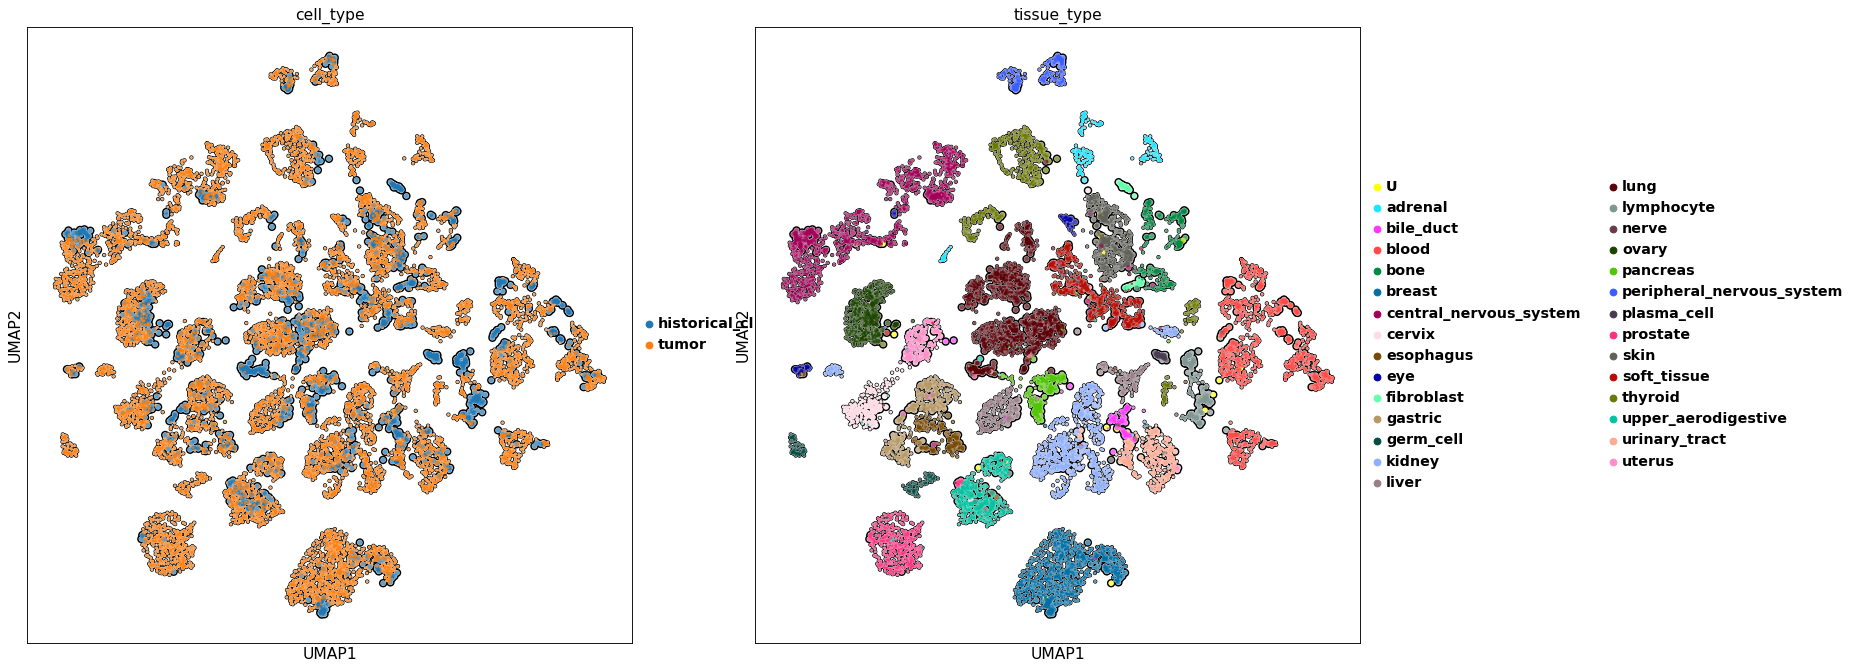

In [276]:
evaluator.plot_latent(umap_kwargs=dict( 
                            n_components=2,
                            min_dist=0.5,
                            alpha=1,
                            spread=1,
                            random_state=None), 
        color=['cell_type', 'tissue_type'],
        projection="2d",
        add_outline=True,
        size=[80]*len(dataset[dataset.obs['cell_type']=='historical_cl']) + [20]*len(dataset[dataset.obs['cell_type']=='tumor']))

/home/jeremie/celligner2/celligner2/plotting/_alluvial.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(alluvial_fan)


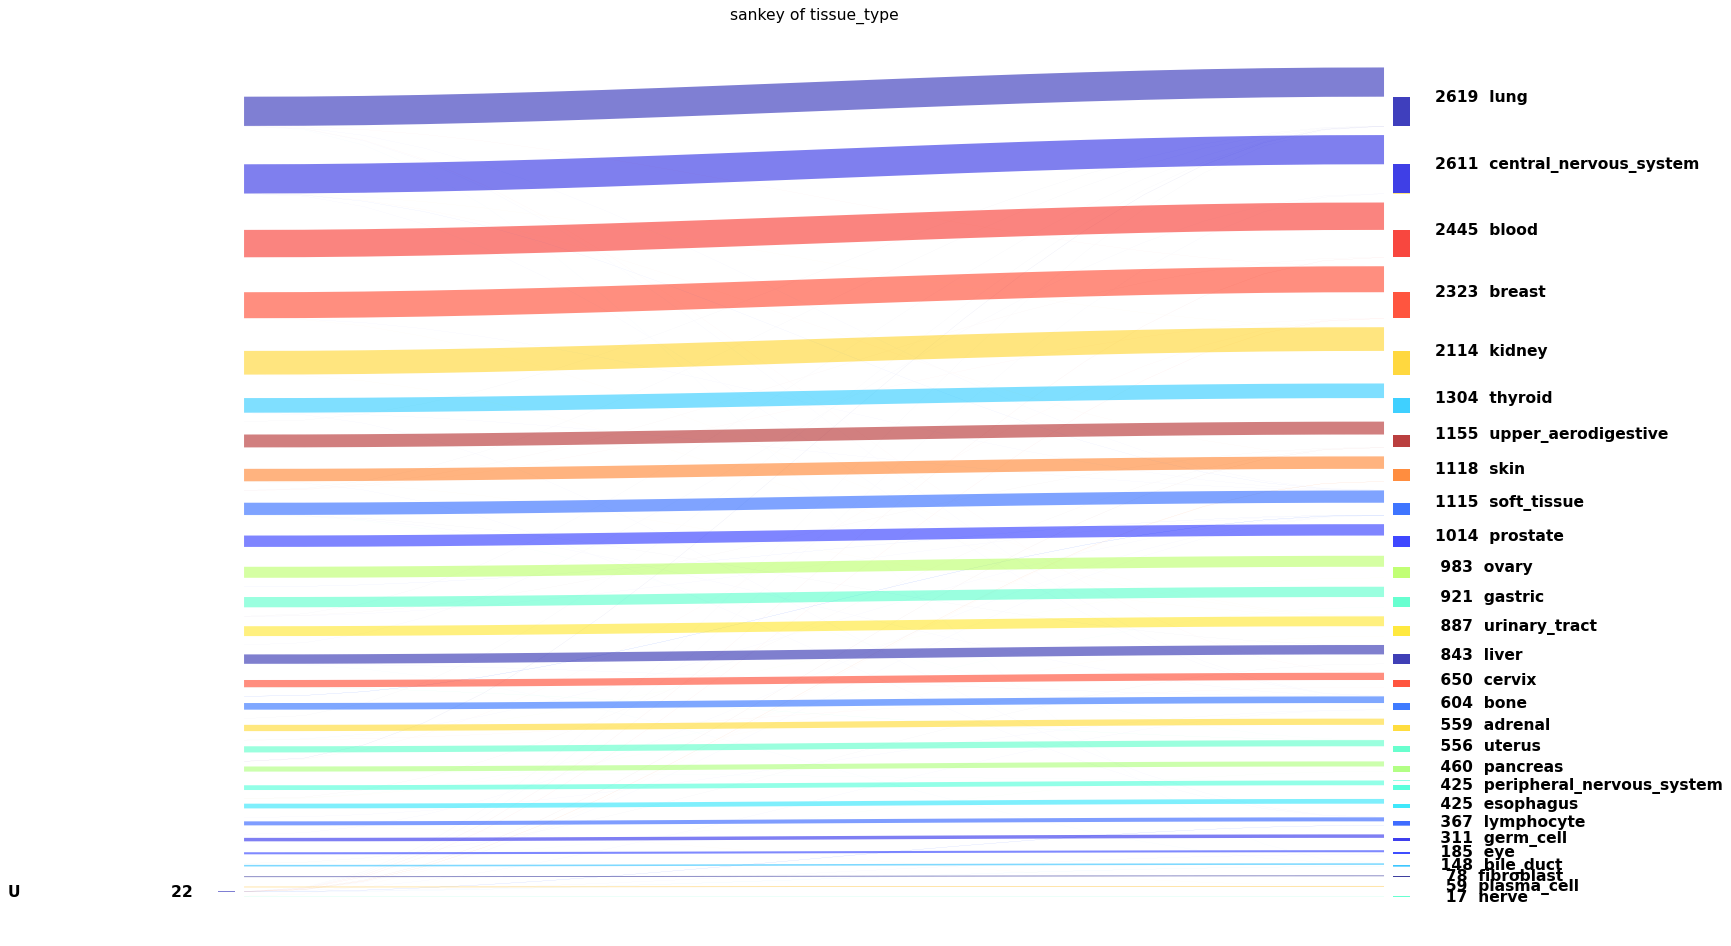

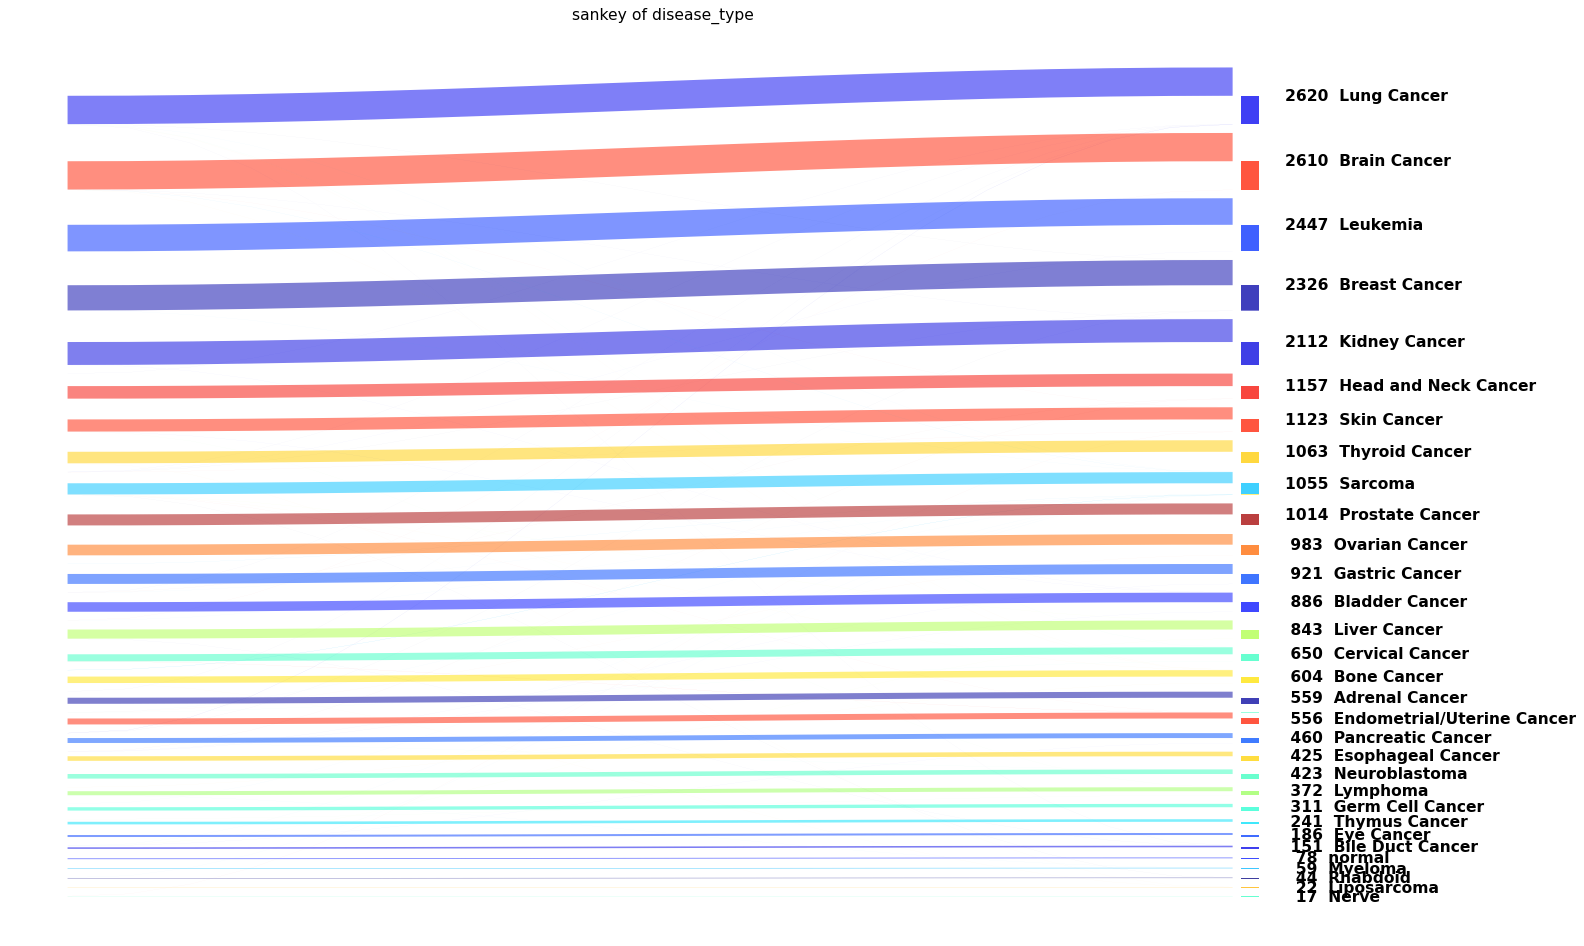

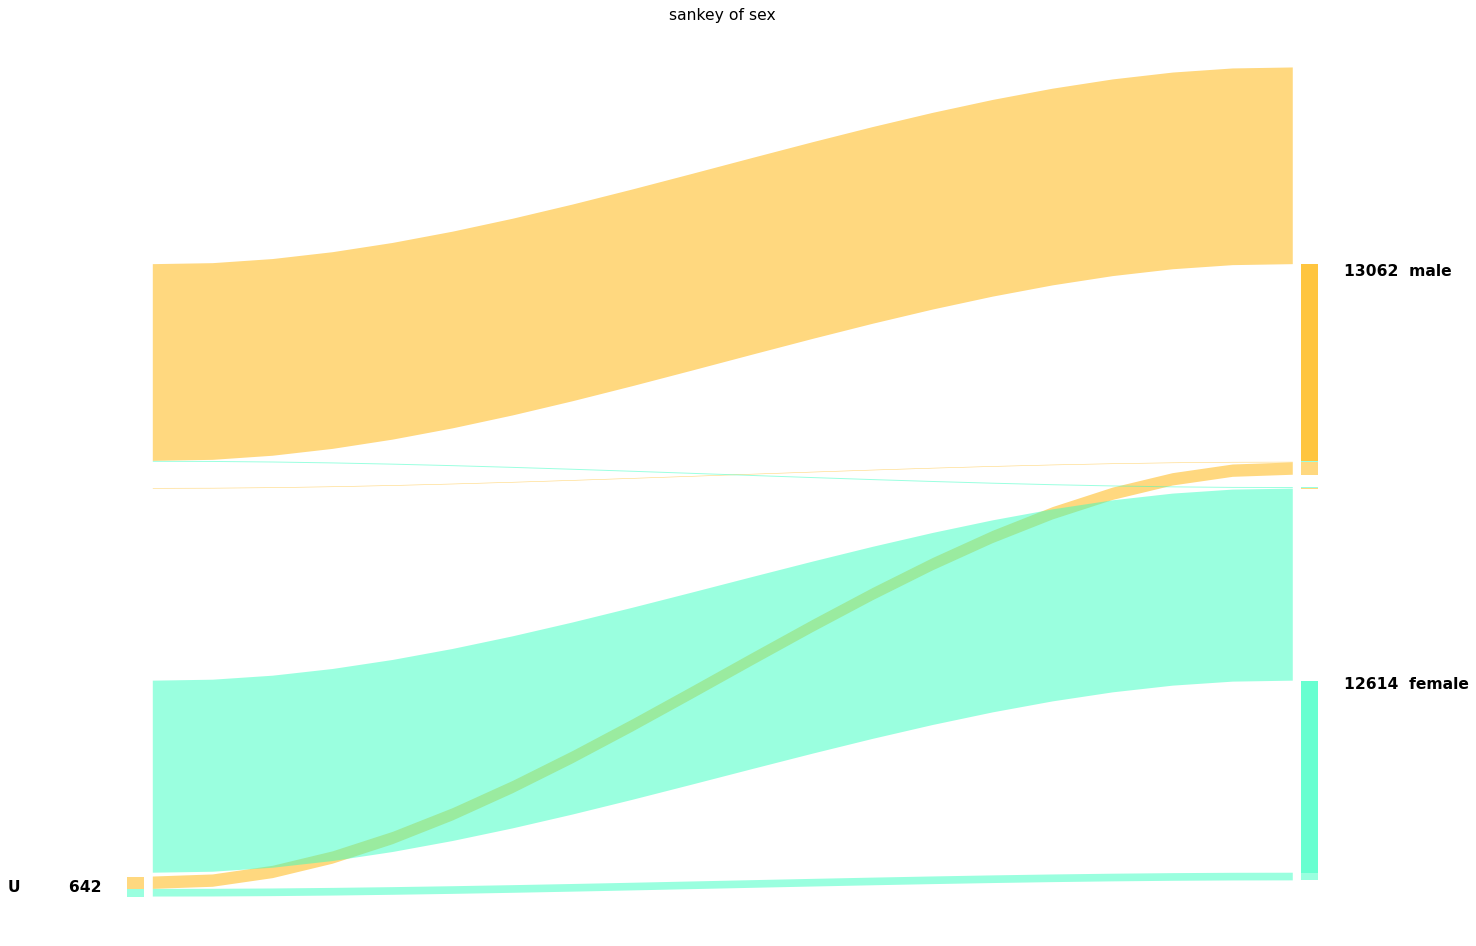

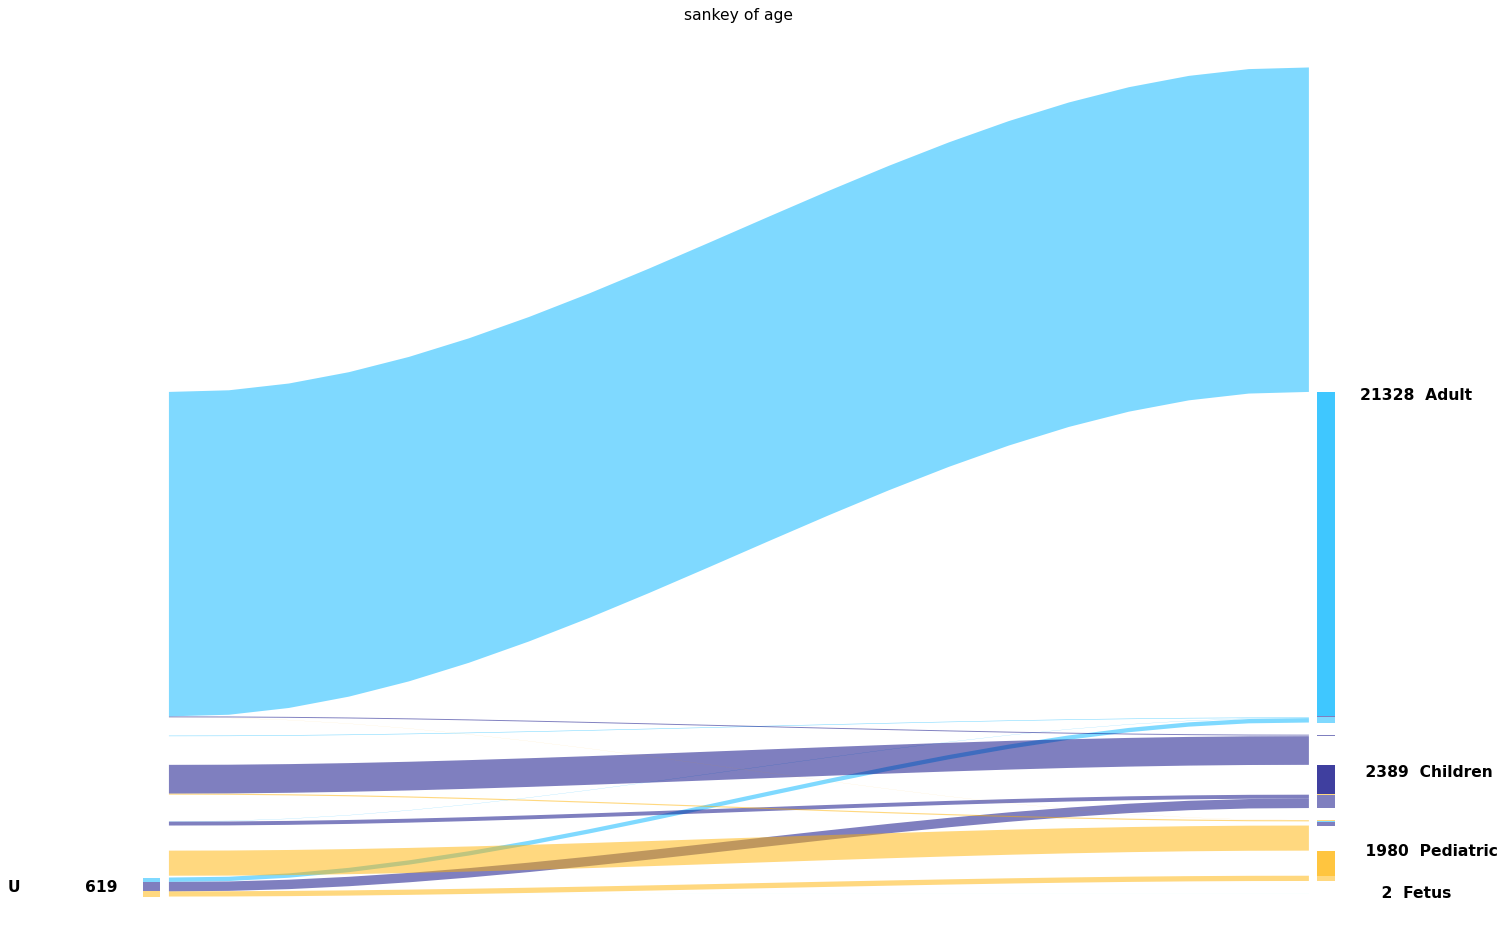

In [277]:
evaluator.plot_classification(classes=['tissue_type', 'disease_type', 'sex', 'age'])

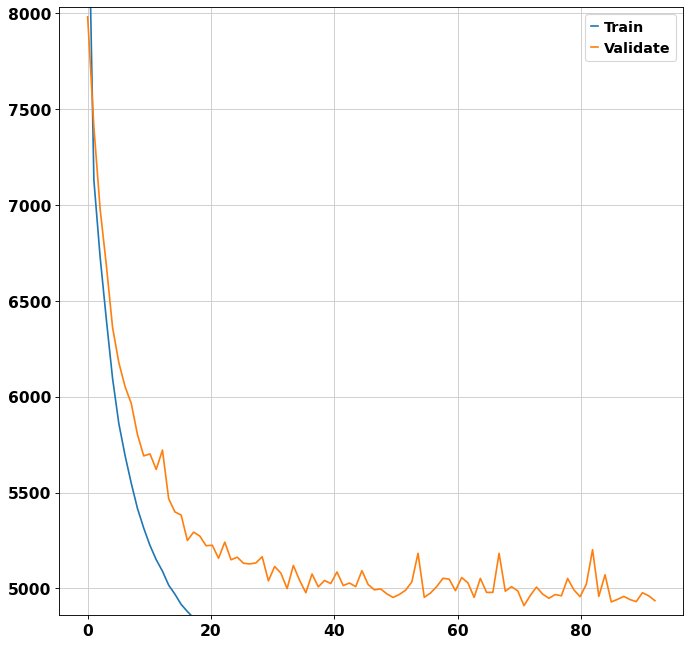

<Figure size 800x800 with 0 Axes>

In [285]:
evaluator.plot_history()

In [279]:
evaluator.get_asw()
evaluator.get_latent_score()
evaluator.get_nmi()

silhouette score...
ASW on batch: 0.8548363904456818
ASW on celltypes: 0.626011461019516
Calculating EBM with n_cat = 29
Latent-Space Score EBM+KNN, EBM, KNN: 0.93, 0.03, 0.90


ModuleNotFoundError: No module named 'louvain'

In [297]:
evaluator.adata_latent.shape

(13159, 16)

In [302]:
## what would it look like as tumor
print(cl2.adata.obs.iloc[0])
cl2.reconstruct(evaluator.adata_latent[0],pd.DataFrame(data=['tumor'], columns=['cell_type']))

disease_type                       Lung Cancer
cell_type                        historical_cl
age                                      Adult
sex                                       male
reference                                 hg38
participant_id                     PT-YXSld526
ends                                paired end
dataset                                   ccle
method                                    bulk
sequencer                  Illumina Hiseq 2000
disease_subtype                          NSCLC
tissue_type                               lung
celligner2_size_factors            6561.910156
celligner2_labeled                         0.0
Name: ACH-001113, dtype: object


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [246]:
sc.tl.louvain(adata_latent)

ModuleNotFoundError: No module named 'louvain'

## add many many more datasets